# Library imports

In [ ]:
!pip install fastai

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 

In [ ]:
from fastai.vision.all import *
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import cv2
import matplotlib.patches as patches

# Training data
For local runtime:


1.   Set `local_runtime=True`in cell below
2.   Upload `data.zip`

For Google hosted runtime:
1.   Set `local_runtime=False`in cell below
2. Make sure `data` is in you Google Drive



In [ ]:
local_runtime=True

if local_runtime:
  !unzip -oq data.zip
  path = Path('/content/data')
else:
  from google.colab import drive
  drive.mount('/content/drive')
  path = Path('/content/drive/MyDrive/data')

path_im = path/'images'
path_lbl = path/'labels'
fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)
get_msk = lambda o: path/'labels'/f'{o.stem}.png'
codes = np.loadtxt(path/'codes.txt', dtype=str)

Let's verify we have access to photos and masks

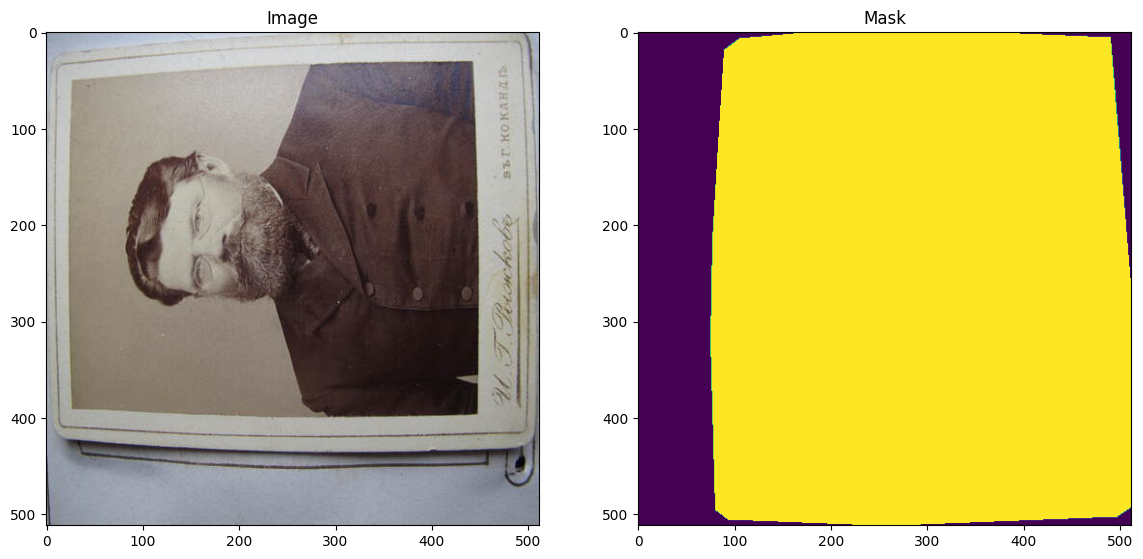

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 7)

img_fn = fnames[10]
img = PILImage.create(img_fn)
ax[0].set_title("Image")
ax[0].imshow(img)
msk = PILMask.create(get_msk(img_fn))
ax[1].set_title("Mask")
ax[1].imshow(msk)

# Data loader

Define

In [ ]:
def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n')
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

half = (256, 256)
vid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])
dls = vid.dataloaders(path/'images', bs=8)
dls.vocab = codes



Verify dataloader

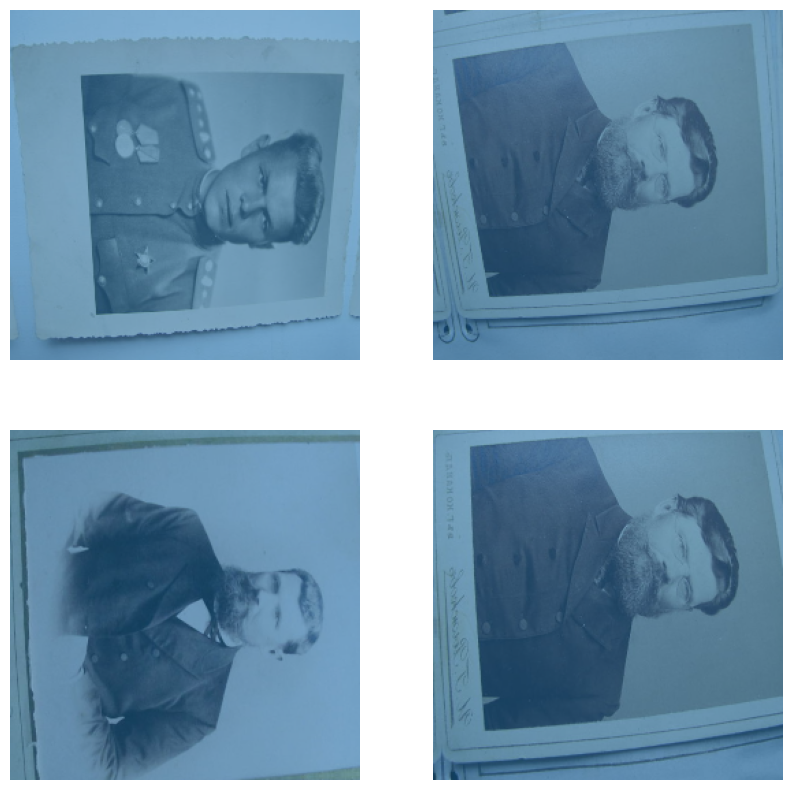

In [ ]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(10,10))

# Segmentation model

Define

In [ ]:
def create_model():
  name2id = {v:k for k,v in enumerate(codes)}
  void_code = name2id['Void']
  def acc_vid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()
  return unet_learner(dls, resnet34, metrics=Dice (axis=1), self_attention=True, act_cls=Mish, opt_func=ranger)

learn = create_model()


Verify

In [ ]:
learn.summary()

# Learn

If you want to regenerate model:
1. Set `do_learn_model=True` in the cell below
2. Download `model_1.pth` from `/content/data`

If you want to use existing model
1. Set `do_learn_model=False` in the cell below
2. Make sure that `model_1.pth` is located in `/content/data`, otherwise upload it


In [ ]:
do_learn_model = False

## Learning rate

In [ ]:
if do_learn_model:
  learn.lr_find()

In [ ]:
lr = 1e-4

In [ ]:
if do_learn_model:
  learn.fit_flat_cos(20, slice(lr))

In [ ]:
if do_learn_model:
  learn.save(path/'stage-1')
  learn.load(path/'stage-1');

In [ ]:
if do_learn_model:
  learn.show_results(max_n=4, figsize=(4,8))

In [ ]:
if do_learn_model:
  lrs = slice(lr/400, lr/4)
  learn.unfreeze()
  learn.fit_flat_cos(12, lrs)

In [ ]:
if do_learn_model:
  learn.save(path/'model_1')
else:
  learn.load(path/'model_1')

# Verify model output

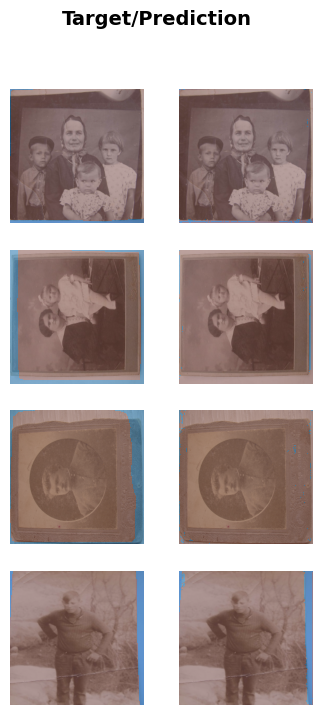

In [ ]:
learn.show_results(max_n=4, figsize=(4,8))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


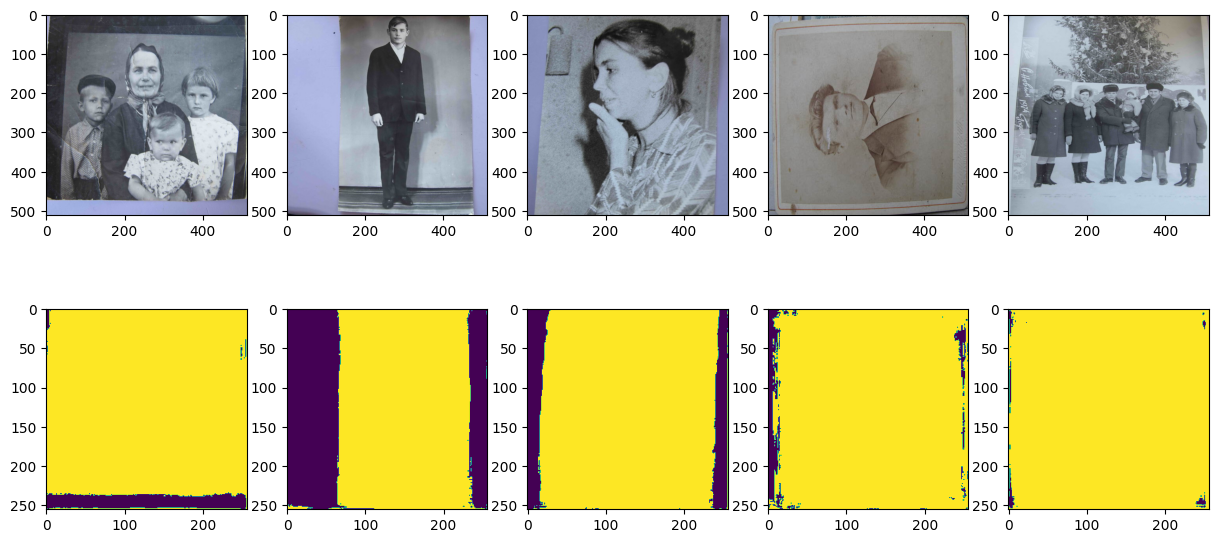

In [ ]:
preds = learn.get_preds(dl=learn.dls.test_dl(fnames[:5]))
fig, ax = plt.subplots(2, 5)
fig.set_size_inches(15, 7)

for i in range(len(preds[0])):
  ax[0][i].imshow(PILImage.create(fnames[i]))
  ax[1][i].imshow(preds[0][i].argmax(dim=0))


# Determine crop by void segmentation

In [ ]:
def round_up(value):
  return round(float(value.numpy()), 1)

def row_quality(image, row_index, left_index, right_index):
    return round_up(sum(image[row_index][left_index:right_index])/(right_index-left_index))

def col_quality(image, col_index, top_index, bottom_index):
    return round_up(sum([row[col_index] for row in image[top_index:bottom_index]])/(bottom_index-top_index))

def best_cut(image, offsets):
    height = len(image)
    width = len(image[0])
    left, top, right, bottom = offsets
    min_x=left
    min_y=top
    max_x=width-right-1
    max_y=height-bottom-1
    crop_limit_x=(max_x-min_x)//2
    crop_limit_y=(max_y-min_y)//2
    top_cuts = [(row_quality(image, min_y+(cut-1), min_x, max_x), -cut, (left, top+cut, right, bottom)) for cut in range(1, crop_limit_y) ]
    bottom_cuts = [(row_quality(image, max_y-(cut-1), min_x, max_x), -cut, (left, top, right, bottom+cut)) for cut in range(1, crop_limit_y) ]
    left_cuts = [(col_quality(image, min_x+(cut-1), min_y, max_y), -cut, (left+cut, top, right, bottom)) for cut in range(1, crop_limit_x) ]
    right_cuts = [(col_quality(image, max_x-(cut-1), min_y, max_y), -cut, (left, top, right+cut, bottom)) for cut in range(1, crop_limit_x) ]

    all_cuts = top_cuts+bottom_cuts+left_cuts+right_cuts
    worst_quality, _, worst_offset = min(all_cuts)
    return worst_offset, worst_quality

def find_best_offsets(image):
    height = len(image)
    width = len(image[0])
    offsets = (0,0,0,0)
    for i in range(100):
        candidate_offsets, worst_quality = best_cut(image, offsets)
        # print(candidate_offsets, worst_quality)
        if worst_quality>0.9:
            return offsets
        offsets = candidate_offsets




# Test image crop

(0, 0, 16, 0) 0.0
(7, 0, 16, 0) 0.0
(9, 0, 16, 0) 0.1
(9, 0, 17, 0) 0.1
(11, 0, 17, 0) 0.2
(11, 0, 18, 0) 0.2
(12, 0, 18, 0) 0.3
(14, 0, 18, 0) 0.4
(14, 0, 19, 0) 0.4
(16, 0, 19, 0) 0.5
(16, 0, 20, 0) 0.5
(18, 0, 20, 0) 0.7
(18, 0, 21, 0) 0.8
(19, 0, 21, 0) 0.8
(25, 0, 21, 0) 0.9
(25, 0, 24, 0) 0.9
(25, 0, 24, 126) 1.0
Crop left:25 top:0 right:24 bottom:0


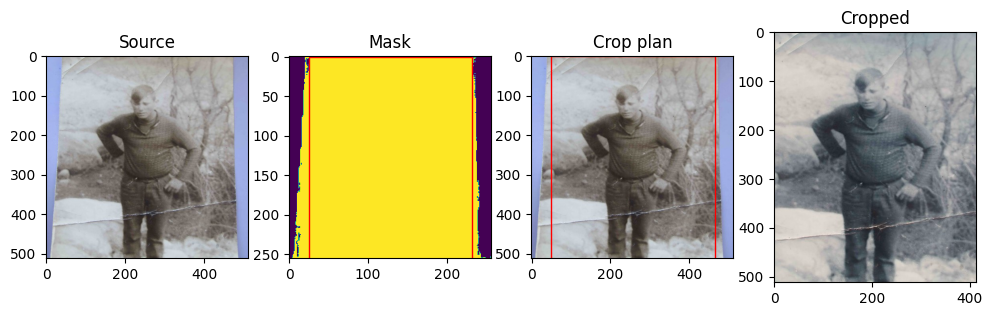

In [ ]:
sample_image_name = '/content/data/images/01v0_0_36_0_35.jpg'
pred_arx = learn.get_preds(dl=learn.dls.test_dl(sample_image_name))[0][0].argmax(dim=0)
width = pred_arx.shape[0]
height = pred_arx.shape[1]
fbo = find_best_offsets(pred_arx)
left, top, right, bottom = fbo
print(f"Crop left:{left} top:{top} right:{right} bottom:{bottom}")

sample_image = PILImage.create(sample_image_name)
sample_image_width = sample_image.shape[0]
sample_image_height = sample_image.shape[1]
sample_min_x = left*2
sample_min_y = top*2
sample_max_x = sample_image_width-right*2
sample_max_y = sample_image_height-bottom*2

fig, ax = plt.subplots(1, 4)
fig.set_size_inches(12, 5)
ax[0].set_title("Source")
ax[0].imshow(sample_image)
ax[1].set_title("Mask")
ax[1].imshow(pred_arx)
ax[1].add_patch(patches.Rectangle((left, top), width-left-right, height-top-bottom,
                                  linewidth=1, edgecolor='r', facecolor='none'))
ax[2].set_title("Crop plan")
ax[2].imshow(sample_image)
ax[2].add_patch(patches.Rectangle((sample_min_x, sample_min_y), sample_max_x-sample_min_x, sample_max_y-sample_min_y,
                                  linewidth=1, edgecolor='r', facecolor='none'))
ax[3].set_title("Cropped")
ax[3].imshow(cv2.imread(str(sample_image_name))[sample_min_y:sample_max_y, sample_min_x:sample_max_x])

# Batch processing

Saving 4v4_0_73_0_64.jpg to 4v4_0_73_0_64.jpg
Saving 08v0_2_43_0_59.jpg to 08v0_2_43_0_59.jpg
Saving 07v0_10_5_22_0.jpg to 07v0_10_5_22_0.jpg
Saving 06v0_19_5_72_6.jpg to 06v0_19_5_72_6.jpg
Изменение размера изображения '4v4_0_73_0_64.jpg':


Обрезание '4v4_0_73_0_64.jpg':
Сохранен как 'cropped_4v4_0_73_0_64.jpg':
Изменение размера изображения '08v0_2_43_0_59.jpg':


Обрезание '08v0_2_43_0_59.jpg':
Сохранен как 'cropped_08v0_2_43_0_59.jpg':
Изменение размера изображения '07v0_10_5_22_0.jpg':


Обрезание '07v0_10_5_22_0.jpg':
Сохранен как 'cropped_07v0_10_5_22_0.jpg':
Изменение размера изображения '06v0_19_5_72_6.jpg':


Обрезание '06v0_19_5_72_6.jpg':
Сохранен как 'cropped_06v0_19_5_72_6.jpg':


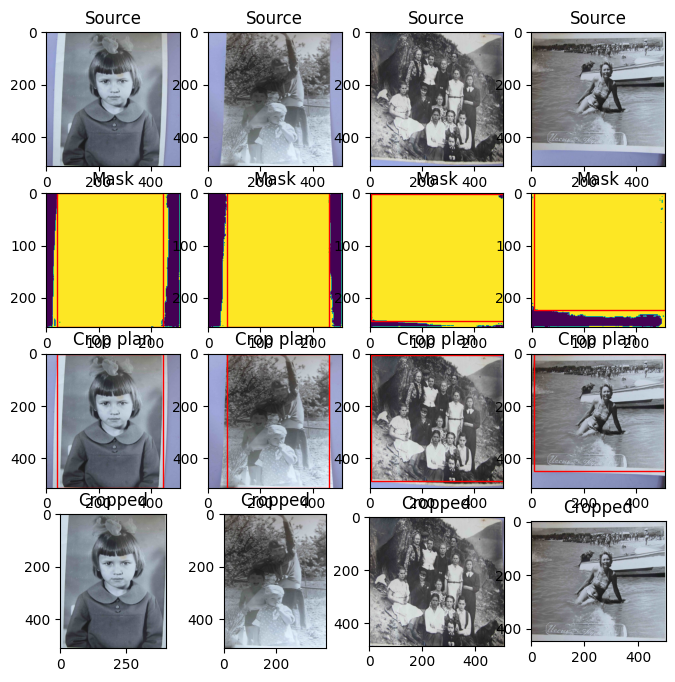

In [ ]:
import io
from google.colab import files
from PIL import Image

# Загрузка изображений
uploaded_images = files.upload()

target_size = (256, 256)
fig, ax = plt.subplots(4, len(uploaded_images), squeeze=False)
fig.set_size_inches(2*len(uploaded_images), 8)

for index, (image_name, image_content) in enumerate(uploaded_images.items()):
  print(f"Изменение размера изображения '{image_name}':")
  image = Image.open(io.BytesIO(image_content))
  resized_image = image.resize(target_size)
  pred_arx = learn.predict(resized_image)[0]
  print(f"Обрезание '{image_name}':")
  pred_width = pred_arx.shape[0]
  pred_height = pred_arx.shape[1]
  pred_fbo = find_best_offsets(pred_arx)
  pred_left, pred_top, pred_right, pred_bottom = pred_fbo

  image_width = image.shape[0]
  image_height = image.shape[1]
  image_min_x = int(pred_left/pred_width*image_width)
  image_max_x = int((1-pred_right/pred_width)*image_width)
  image_min_y = int(pred_top/pred_height*image_height)
  image_max_y = int((1-pred_bottom/pred_height)*image_height)

  cropped_image = np.array(image.convert('RGB'))[image_min_y:image_max_y, image_min_x:image_max_x]
  cv2.imwrite(f"cropped_{image_name}", cropped_image)
  print(f"Сохранен как 'cropped_{image_name}':")

  ax[0][index].set_title("Source")
  ax[0][index].imshow(image)
  ax[1][index].set_title("Mask")
  ax[1][index].imshow(pred_arx)
  ax[1][index].add_patch(patches.Rectangle((pred_left, pred_top), pred_width-pred_left-pred_right, pred_height-pred_top-pred_bottom,
                                  linewidth=1, edgecolor='r', facecolor='none'))
  ax[2][index].set_title("Crop plan")
  ax[2][index].imshow(image)
  ax[2][index].add_patch(patches.Rectangle((image_min_x, image_min_y), image_max_x-image_min_x, image_max_y-image_min_y,
                                    linewidth=1, edgecolor='r', facecolor='none'))

  ax[3][index].set_title("Cropped")
  ax[3][index].imshow(cropped_image)
# resized_image


the end